# Heterogeneity in the relationship between BMI and risk biomarkers

---

***Authors:***

- Daniel E. Coral

- Femke Smit

- Elena Santos

- Ali Farzaneh

---

## Introduction

This is a guideline to be followed by analysts in SOPHIA who are participating in the cross-sectional clustering project in the general population in Working Group 1. The idea is to standardize every step of the analysis across cohorts.

Not everyone has to follow all the steps, as we require different things from every cohort. We have divided the participating cohorts into 4 groups:

|Cohort group|Cohorts|
|-:|-:|
|*Discovery*|UK Biobank|
|*Validation*|Maastricht|
||Rotterdam|
||GHS|
|*Mental health*|Girona|
||Maastricht|
|*Intervention*|SCALE|
||ABOS|

This guideline is designed to be applied in discovery and validation cohorts. We will then apply what we learn in these cohorts to the mental health and intervention cohorts.

---

As a background, generally the relationship between BMI and multiple diseases is assumed to follow a continuum -- the higher the BMI, the higher the risk. However, it has also been found that in certain groups of people this relationship is disproportionally stronger or weaker for any given BMI. Our objective is to test the hypothesis that clustering-based approaches can be used to better capture these subgroups. An overview of the steps of our pipeline to test this hypothesis is shown in Figure 1.

|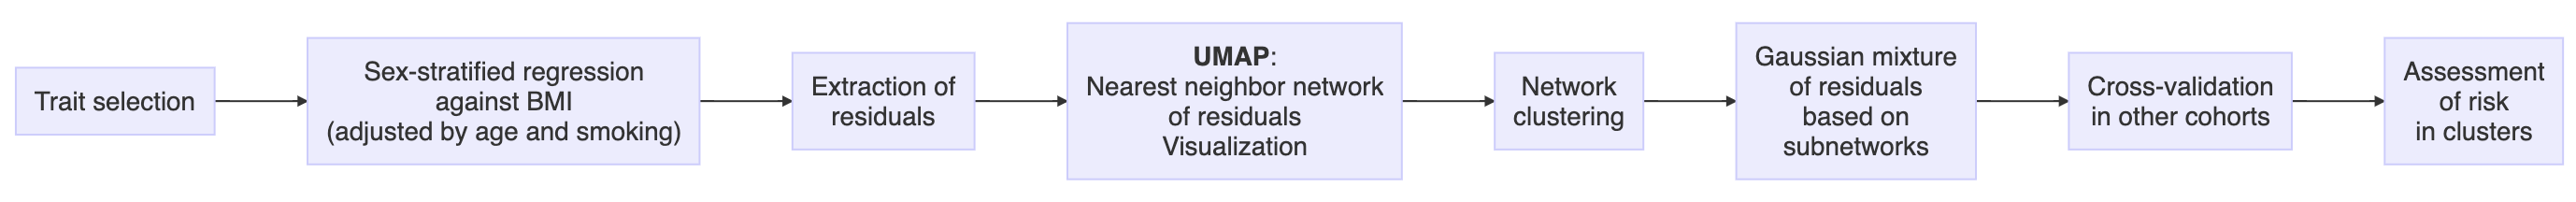|
|-|
|*Figure 1. Pipeline overview*|

---

## Software

All steps are intended to be followed in the R environment. To facilitate the analyses we have put together a list of functions that can be used to run every step of this guideline. They are located in the accompanying file `cross_sectional_FX.R`, which you can load like this:

In [1]:
source("cross_sectional_FX.R")

These functions have dependencies on the following packages:

In [2]:
suppressMessages({
    library(tibble)
    library(readr)
    library(dplyr)
    library(tidyr)
    library(purrr)
    library(uwot)
    library(igraph)
    library(mvtnorm)
})

The environment where discovery analysis in UK Biobank was executed is then the following:

In [3]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: RHEL

Matrix products: default
BLAS/LAPACK: /gpfs/gpfs0/Home/daniel_c/miniconda3/envs/NewR/lib/libopenblasp-r0.3.18.so

locale:
[1] C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] mvtnorm_1.1-3    igraph_1.3.0     uwot_0.1.11.9000 Matrix_1.4-1    
[5] purrr_1.0.1      tidyr_1.3.0      dplyr_1.1.2      readr_2.1.4     
[9] tibble_3.2.1    

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.11      pillar_1.9.0     compiler_4.1.2   base64enc_0.1-3 
 [5] tools_4.1.2      digest_0.6.33    uuid_1.0-4       jsonlite_1.8.7  
 [9] evaluate_0.21    lifecycle_1.0.3  lattice_0.20-45  pkgconfig_2.0.3 
[13] rlang_1.1.1      IRdisplay_1.1    cli_3.6.1        IRkernel_1.3    
[17] fastmap_1.1.1    repr_1.1.4       generics_0.1.3   vctrs_0.6.3     
[21] hms_1.1.3        grid_4.1.2       tidyselect_1.2.0 glue_1.6.2      
[25] R6_

---

## Initial input

We have selected 10 traits, based on biological systems that are commonly affected by obesity:

- Blood pressure: SBP and DBP.
- Lipids: HDL, LDL, TG.
- Fat distribution: WHR.
- Glycemia: Fasting glucose.
- Liver metabolism: ALT.
- Kidney function: Creatinine.
- Inflammation: CRP.

The covariates that will be needed are:

- Sex.
- Age.
- Current smoking status, coded as 1 if current smoker, 0 otherwise.


The initial input table should look like the following:

In [4]:
recoded_dat <- read_tsv("../data/recoded_dat.tsv", show_col_types = FALSE)
head(recoded_dat)

eid,age,sex,bmi,whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg,smoking
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000039,44,Male,36.6959,0.9911504,124.5,64.5,34.97,93.0,3.60,1.158,2.800,3.956,5.427,0
1000071,67,Male,39.4807,0.8857143,179.5,103.0,46.74,68.7,9.41,1.372,1.127,2.311,7.079,0
1000088,60,Male,24.2786,0.8761905,152.0,89.0,13.14,80.6,1.20,0.983,1.590,4.200,5.401,0
1000096,41,Male,26.5744,0.9587629,143.0,90.0,30.32,80.1,6.13,1.041,2.713,4.029,4.239,0
1000109,62,Male,33.8719,1.0818182,156.5,104.5,16.26,89.3,14.42,0.890,2.437,3.525,6.100,0
1000117,47,Female,23.8408,0.7254902,147.5,84.0,14.07,61.0,0.24,1.972,0.591,2.252,4.395,0


The units of the contiuous variables we expect to run the analysis:

- Age in years.
- Sex as a string of either "Female" or "Male".
- BMI in kg/m2.
- WHR is unitless, calculated by dividing waist and hip circumferences measured in cm.
- SBP and DBP in mmHg.
- ALT in U/L.
- sCr in umol/L.
- CRP in mg/L.
- HDL in mmol/L.
- TG in mmol/L.
- LDL in mmol/L.
- FG in mmol/L.
- Smoking as a dummy variable: 1 if currently smoking, 0 otherwise.

<font color=red size=3.5>***Note:***</font> 

For the functions included in the `cross_sectional_FX.R` to work, the input table should be ***exactly*** as shown above.

---

## Missing data

Since our clustering method ignores individuals with missing values for any biomarker, the input data should only contain individuals who have all biomarker values. From the previous analyses, we know that:

- Only including complete cases without losing too much data is possible in UK Biobank, Maastricht, GHS and ABOS.
- In Rotterdam the initial input table contains some values have been imputed using a random forest algorithm.
- In Girona only a small subset of individuals have CRP values.
- In SCALE there are values for waist but not for hip circumference, so it is not possible to calculate WHR.

Based on these observations we have made the following decisions on how to deal with missing values:

|How to handle missing values|Cohorts|
|-:|-:|
|Only include complete cases.|UK Biobank|
||Maastricht|
||GHS|
||ABOS|
|||
|Use data that has been imputed.|Rotterdam|
|||
|Retain all individuals.|Girona|
||SCALE|

***For the cohorts in the last group***, to be able to apply our method, we will assume that BMI explains the variability in the biomarkers that are missing. This assumption is based on what we have observed in the other cohorts. In practice, this means that the clustering method will focus on the biomarkers that are available to group individuals into clusters. The input table should still have the same columns so that the functions in `cross_sectional_FX.R` work properly.

---

## Remove possible errors in measurement

In discovery and validation cohorts we will exclude biomarker measurements that are 5 SD away from the mean, under the assumption that these are most likely measurement errors. This can be done using the `remove_outliers` function that we have provided, which replaces outliers with `NA` values. Then we again make sure to have only complete cases:

In [5]:
recoded_dat <- mutate(recoded_dat, 
                      across(c(bmi, whr, sbp, dbp, alt, scr, crp, hdl, tg, ldl, fg), 
                             ~remove_outliers(.x, sdunits = 5)))
recoded_dat <- recoded_dat[complete.cases(recoded_dat),]

---

## Stratify by sex

All the pipeline is applied separately in each sex group. The functions we have designed work on a list containing two dataframes for each sex group, which we can obtain like this:

In [6]:
strat_dat <- split(recoded_dat, ~sex)

To see the first lines of the two elements in the list:

In [7]:
lapply(strat_dat, head)

eid,age,sex,bmi,whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg,smoking
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000117,47,Female,23.8408,0.7254902,147.5,84.0,14.07,61.0,0.24,1.972,0.591,2.252,4.395,0
1000132,43,Female,35.6559,0.8403361,137.0,100.5,18.89,60.5,4.31,1.236,2.037,3.686,5.214,0
1000176,69,Female,38.1271,0.8897638,137.5,93.5,36.39,68.9,3.69,1.601,1.988,4.551,4.266,0
1000223,63,Female,25.4603,0.7789474,163.0,94.0,6.10,67.1,1.29,1.453,2.829,3.491,5.876,0
1000282,48,Female,25.4297,0.7708333,135.5,89.0,9.63,46.2,0.16,2.185,0.722,3.584,5.212,0
1000367,42,Female,19.3280,0.6777778,107.0,72.5,9.34,57.1,0.69,2.346,0.395,3.072,4.649,0
eid,age,sex,bmi,whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg,smoking
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000039,44,Male,36.6959,0.9911504,124.5,64.5,34.97,93.0,3.60,1.158,2.800,3.956,5.427,0


---

## Summary of initial input

We need a table summarising the initial input, which can be generated like this:

In [8]:
gendesc_tab <- get_general_descriptives(strat_dat)
gendesc_tab

sex,Variable,Type,N,N_miss,Summary1,Summary2
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
Female,bmi,Numeric,77207,0,27.11 (5.07),26.18 (19.68 - 23.52 - 29.78 - 39.67)
Female,age,Numeric,77207,0,57.45 (7.84),59 (42 - 52 - 64 - 69)
Female,smoking,Categorical,77207,0,0,70355 (91.13%)
Female,smoking,Categorical,77207,0,1,6852 (8.87%)
Female,whr,Numeric,77207,0,0.82 (0.07),0.81 (0.7 - 0.77 - 0.86 - 0.96)
Female,sbp,Numeric,77207,0,137.51 (19.47),135.5 (105.5 - 123.5 - 150 - 180)
Female,dbp,Numeric,77207,0,81.49 (9.92),81 (63.5 - 74.5 - 88 - 102)
Female,alt,Numeric,77207,0,19.98 (9.71),17.57 (8.97 - 13.96 - 23 - 46.41)
Female,scr,Numeric,77207,0,64.31 (10.74),63.2 (46.9 - 57.2 - 70 - 88.1)


For smoking:

- `Summary1` contains the categories.
- `Summary2` contains the proportion of each category.

For the rest (continuous) variables:

- `Summary1` contains the mean and standard deviation.
- `Summary2` contains the median and percentiles 2.5, 25, 75 and 97.5.

---

## Estimates of BMI-biomarker associations

The first step of the pipeline is to generate sex-specific linear models of BMI for each variable, adjusting for age, and smoking. To do that we have the following function:

In [9]:
mods <- get_bmimods(strat_dat)

The result is a table with a column that contains the models specific for each sex and biomarker:

In [10]:
print(mods)

# A tibble: 20 x 3
   sex    Biomarker mod   
   <chr>  <chr>     <list>
 1 Female whr       <lm>  
 2 Female sbp       <lm>  
 3 Female dbp       <lm>  
 4 Female alt       <lm>  
 5 Female scr       <lm>  
 6 Female crp       <lm>  
 7 Female hdl       <lm>  
 8 Female tg        <lm>  
 9 Female ldl       <lm>  
10 Female fg        <lm>  
11 Male   whr       <lm>  
12 Male   sbp       <lm>  
13 Male   dbp       <lm>  
14 Male   alt       <lm>  
15 Male   scr       <lm>  
16 Male   crp       <lm>  
17 Male   hdl       <lm>  
18 Male   tg        <lm>  
19 Male   ldl       <lm>  
20 Male   fg        <lm>  


As an example, we can print the summary of the female model for CRP:

In [11]:
summary(mods$mod[mods$sex == "Female" & mods$Biomarker == "crp"][[1]])


Call:
lm(formula = reformulate(response = biomarker, termlabels = c(BODYSIZEINDEX, 
    COVARIATES)), data = X, na.action = na.exclude)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.7411 -1.4397 -0.6721  0.3533 24.1163 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.494409   0.093488  -58.77   <2e-16 ***
bmi          0.251869   0.002067  121.88   <2e-16 ***
age          0.019570   0.001341   14.60   <2e-16 ***
smoking      0.735783   0.036928   19.93   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.906 on 77203 degrees of freedom
Multiple R-squared:  0.1677,	Adjusted R-squared:  0.1677 
F-statistic:  5187 on 3 and 77203 DF,  p-value: < 2.2e-16


We then use this table to generate a table containing the estimates of the effect of BMI as well as the covariates on every biomarker:

In [12]:
bmicoefs_tab <- get_bmicoefs(mods)
bmicoefs_tab

sex,Biomarker,term,Estimate,SE,lowerCI,upperCI
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Female,whr,(Intercept),0.57262,0.00195,0.56879,0.57645
Female,whr,bmi,0.00623,0.00004,0.00615,0.00632
Female,whr,age,0.00131,0.00003,0.00125,0.00136
Female,whr,smoking,0.02104,0.00077,0.01952,0.02255
Female,sbp,(Intercept),69.54710,0.57139,68.42717,70.66703
Female,sbp,bmi,0.59574,0.01263,0.57099,0.62050
Female,sbp,age,0.90572,0.00819,0.88966,0.92178
Female,sbp,smoking,-2.46168,0.22570,-2.90406,-2.01930
Female,dbp,(Intercept),63.15773,0.30513,62.55968,63.75578


---

## Generate table with residual values

The next step in the pipeline is to calculate for each individual how much they deviate from the expected given the BMI. To do that we have the following function:

In [13]:
residtab <- get_residtabs(strat_dat, mods)

In [14]:
lapply(residtab, head)

eid,whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000117,-0.9414227,1.1926183,0.5116076,-0.3587541,-0.16796651,-0.409575658,0.8523580,-0.7891492,-1.3763833,-0.69260619
1000132,-0.1764123,0.4090741,1.5780902,-0.4004599,-0.43192667,-0.006100145,-0.2651806,0.4634338,0.2519958,0.52816234
1000176,-0.1761241,-0.9715905,0.5396229,1.0581126,0.09472525,-0.608770375,0.7009941,-0.3573226,0.6461341,-1.72033089
1000223,-0.5719758,1.1950790,1.3753292,-1.4711989,0.24147612,-0.296361047,-0.6683174,1.7436043,-0.3128673,1.45522051
1000282,-0.3793309,0.4126554,0.9391211,-0.9258069,-1.59984781,-0.581564633,1.5766624,-0.7408929,0.1331143,0.64786229
1000367,-1.1563479,-0.6814000,-0.4049804,-0.5796283,-0.39864794,0.170122557,1.6129248,-0.6407118,-0.2604987,-0.04562832
eid,whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000039,-0.1453374,-0.8863206,-2.6078481,-0.2862800,0.83536530,0.1778442,0.31312383,0.27893954,0.3116117,0.5178969


---

## Obtaining clusters and probabilities of allocation

We use this residuals to run UMAP, which we use not only to obtain a projection of residual data in 2 dimensions, but also to run a probabilistic network clustering algorithm. We have wrapped all the clustering steps in a single function that we apply to the `residtab` object:

In [15]:
cluster_results <- get_cluster_results(residtab)

Starting analysis for the Female subset:

	1. Setting parameters...

	2. Running UMAP...

	3. Extracting graph...

	4. Initializing graph clustering using the leading eigen vector method...

	5. Optimizing graph clustering using the Leiden algorithm...

	   12 clusters found. Modularity = 0.65.

	6. Extracting cluster membership...

	7. Calculating eigen centrality in clusters...

	8. Calculating Gaussian subdistributions weighted by eigen centralities...

	9. Adding central/concordant subdistribution...

	10. Fitting a mixture of Gaussians with subdistributions found...

		Convergence reached in 33 iterations.

	11. Organizing results...

Done!

Starting analysis for the Male subset:

	1. Setting parameters...

	2. Running UMAP...

	3. Extracting graph...

	4. Initializing graph clustering using the leading eigen vector method...

	5. Optimizing graph clustering using the Leiden algorithm...

	   11 clusters found. Modularity = 0.66.

	6. Extracting cluster membership...

	7. Calculat

The result is a list containing the UMAP model, the parameters of the clusters found, the modularity score, which is a measure of the quality of the network partition, and the allocation probabilities of individuals to all clusters:

In [16]:
lapply(cluster_results, names)

$Female
[1] "umap_model" "probs"      "clusters"   "modularity"

$Male
[1] "umap_model" "probs"      "clusters"   "modularity"

---

## Table summarising clusters

To understand what characterizes the clusters found, we will need a table with descriptives of the distribution of residuals per cluster, which can be generated like this:

In [17]:
clustersummary <- get_clustersummary(cluster_results)

In [18]:
head(clustersummary)

sex,cluster,trait,center,SD,weight
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Female,cluster_1,whr,-0.44295193,0.6694450,0.07693544
Female,cluster_1,sbp,1.71672362,0.7927006,0.07693544
Female,cluster_1,dbp,1.61576997,0.7670144,0.07693544
Female,cluster_1,alt,-0.26560810,0.5003358,0.07693544
Female,cluster_1,scr,-0.07000074,0.7440536,0.07693544
Female,cluster_1,crp,-0.24550884,0.4025488,0.07693544


We also need the distribution of the biomarkers in the clusters in their natural scale. To calculate this for a specific cluster, we use all individuals, and weigh each individual by their corresponding cluster allocation probability. The function for this is the following:

In [19]:
cluster_descriptives <- get_cluster_descriptives(cluster_results, strat_dat)

In [20]:
head(cluster_descriptives)

sex,cluster,TotalN,Weighted_N,N80Perc,Variable,Type,Summary1,Summary2
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
Female,cluster_1,77207,5939.95,3143,bmi,Numeric,26.11 (4.4),25.37 (19.56 - 23.06 - 28.39 - 36.85)
Female,cluster_1,77207,5939.95,3143,age,Numeric,57.4 (7.85),58.99 (41.93 - 51.16 - 64 - 69)
Female,cluster_1,77207,5939.95,3143,smoking,Categorical,0,91.49 %
Female,cluster_1,77207,5939.95,3143,smoking,Categorical,1,8.51 %
Female,cluster_1,77207,5939.95,3143,whr,Numeric,0.79 (0.05),0.79 (0.69 - 0.75 - 0.82 - 0.9)
Female,cluster_1,77207,5939.95,3143,sbp,Numeric,163.25 (17.93),162.19 (131.22 - 150.53 - 174.58 - 201.53)


---

## Relationship between BMI and biomarkers in each cluster

Given that the relationship between BMI and biomarkers is expected to be different in these clusters compared to the overall relationship found above, we will quantify how much it changed by comparing models weighted by probabilities of each cluster. The function is the following:

In [21]:
clusbmicoefs <- get_bmicoefs_clusters(cluster_results, strat_dat)

In [22]:
head(clusbmicoefs)

sex,cluster,Biomarker,term,Estimate,SE,lowerCI,upperCI
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Female,cluster_1,whr,(Intercept),0.57235,0.00152,0.56936,0.57533
Female,cluster_1,whr,bmi,0.00588,0.00004,0.00581,0.00595
Female,cluster_1,whr,age,0.00105,0.00002,0.00101,0.00109
Female,cluster_1,whr,smoking,0.02069,0.00058,0.01954,0.02183
Female,cluster_1,sbp,(Intercept),86.92860,0.52788,85.89396,87.96325
Female,cluster_1,sbp,bmi,0.59831,0.01274,0.57334,0.62328


---

## Gathering and saving results

We'll save all results in a single file:

In [63]:
result_file <- list(
    General_descriptives = gendesc_tab,
    BMI_coefficients = bmicoefs_tab,
    Cluster_results = cluster_results,
    Cluster_summary = clustersummary,
    Cluster_descriptives = cluster_descriptives,
    Cluster_BMI_coefficients = clusbmicoefs
)

In [64]:
save(result_file, file = "../data/ukb/result_file.RData")

---

## Uploading results

We require that you upload the 'result_file.RData' file, which does not contain any individual level data, to the Teams folder in SOPHIA, which would be located here:

> CrossWP > Analyst working groups > WG1 > UMAP_project > *cohort_name* > data

---

## Saving discovery cohort used

In [66]:
save(strat_dat, file = "../data/ukb/strat_dat.RData")